In [1]:
import yfinance as yf
import pandas as pd

# Fetch historical data for a set of stocks
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']

# Display the first few rows of the data
print(data.head())


[*********************100%***********************]  4 of 4 completed

Ticker                          AAPL       AMZN      GOOGL        MSFT
Date                                                                  
2020-01-02 00:00:00+00:00  72.876114  94.900497  68.264961  153.938202
2020-01-03 00:00:00+00:00  72.167595  93.748497  67.907852  152.021393
2020-01-06 00:00:00+00:00  72.742661  95.143997  69.717865  152.414352
2020-01-07 00:00:00+00:00  72.400536  95.343002  69.583206  151.024673
2020-01-08 00:00:00+00:00  73.565186  94.598503  70.078476  153.430252


In [2]:
import numpy as np
import cirq

# Calculate expected returns and covariance matrix
returns = data.pct_change().mean().values
cov_matrix = data.pct_change().cov().values

# Define the number of assets
num_assets = len(tickers)

# Create qubits
qubits = [cirq.GridQubit(0, i) for i in range(num_assets)]

# Create a circuit
circuit = cirq.Circuit()

# Add gates to the circuit (example: Hadamard gates)
for qubit in qubits:
    circuit.append(cirq.H(qubit))

# Add measurement
circuit.append(cirq.measure(*qubits, key='result'))

# Display the circuit
print(circuit)


(0, 0): ───H───M('result')───
               │
(0, 1): ───H───M─────────────
               │
(0, 2): ───H───M─────────────
               │
(0, 3): ───H───M─────────────


In [3]:
# Simulate the circuit
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1000)

# Extract the results
histogram = result.histogram(key='result')
print(histogram)


Counter({7: 76, 10: 69, 3: 68, 1: 67, 12: 65, 13: 64, 15: 64, 11: 62, 14: 62, 8: 61, 6: 60, 5: 60, 4: 59, 0: 55, 2: 54, 9: 54})


In [4]:
# Convert the histogram to a probability distribution
probabilities = {k: v / 1000 for k, v in histogram.items()}

# Display the probabilities
print(probabilities)


{7: 0.076, 6: 0.06, 4: 0.059, 2: 0.054, 11: 0.062, 13: 0.064, 10: 0.069, 9: 0.054, 14: 0.062, 1: 0.067, 12: 0.065, 8: 0.061, 0: 0.055, 3: 0.068, 5: 0.06, 15: 0.064}


In [5]:
def portfolio_cost(portfolio, returns, cov_matrix, risk_aversion=0.5):
    # Calculate expected return
    expected_return = np.dot(portfolio, returns)
    
    # Calculate risk (variance)
    risk = np.dot(portfolio.T, np.dot(cov_matrix, portfolio))
    
    # Cost function (to be minimized)
    cost = risk_aversion * risk - (1 - risk_aversion) * expected_return
    return cost


In [7]:
def portfolio_cost(portfolio, returns, cov_matrix, risk_aversion=0.5):
    # Convert portfolio to a NumPy array
    portfolio = np.array(portfolio)
    
    # Calculate expected return
    expected_return = np.dot(portfolio, returns)
    
    # Calculate risk (variance)
    risk = np.dot(portfolio.T, np.dot(cov_matrix, portfolio))
    
    # Cost function (to be minimized)
    cost = risk_aversion * risk - (1 - risk_aversion) * expected_return
    return cost

# Convert binary outcomes to portfolio configurations
portfolios = [list(map(int, f"{k:04b}")) for k in probabilities.keys()]

# Evaluate the cost for each portfolio
costs = [portfolio_cost(portfolio, returns, cov_matrix) for portfolio in portfolios]

# Combine portfolios with their costs
portfolio_costs = list(zip(portfolios, costs))

# Display the portfolio costs
for portfolio, cost in portfolio_costs:
    print(f"Portfolio: {portfolio}, Cost: {cost}")


Portfolio: [0, 1, 1, 1], Cost: 0.0011553292688463793
Portfolio: [0, 1, 1, 0], Cost: 0.0005463060674847043
Portfolio: [0, 1, 0, 0], Cost: 0.00023254026749435565
Portfolio: [0, 0, 1, 0], Cost: -5.005325913977042e-05
Portfolio: [1, 0, 1, 1], Cost: 0.0007225020692405337
Portfolio: [1, 1, 0, 1], Cost: 0.000998173930507132
Portfolio: [1, 0, 1, 0], Cost: 7.825586185456661e-05
Portfolio: [1, 0, 0, 1], Cost: 7.651755595266489e-06
Portfolio: [1, 1, 1, 0], Cost: 0.0010545082139368812
Portfolio: [0, 0, 0, 1], Cost: -0.00016438366341269787
Portfolio: [1, 1, 0, 0], Cost: 0.00037115682397619823
Portfolio: [1, 0, 0, 0], Cost: -0.00024127646897599737
Portfolio: [0, 0, 0, 0], Cost: 0.0
Portfolio: [0, 0, 1, 1], Cost: 0.0001808810602622348
Portfolio: [0, 1, 0, 1], Cost: 0.00044624548604132764
Portfolio: [1, 1, 1, 1], Cost: 0.002076843303282518


In [8]:
# Find the portfolio with the minimum cost
optimal_portfolio = min(portfolio_costs, key=lambda x: x[1])
print(f"Optimal Portfolio: {optimal_portfolio[0]}, Cost: {optimal_portfolio[1]}")


Optimal Portfolio: [1, 0, 0, 0], Cost: -0.00024127646897599737


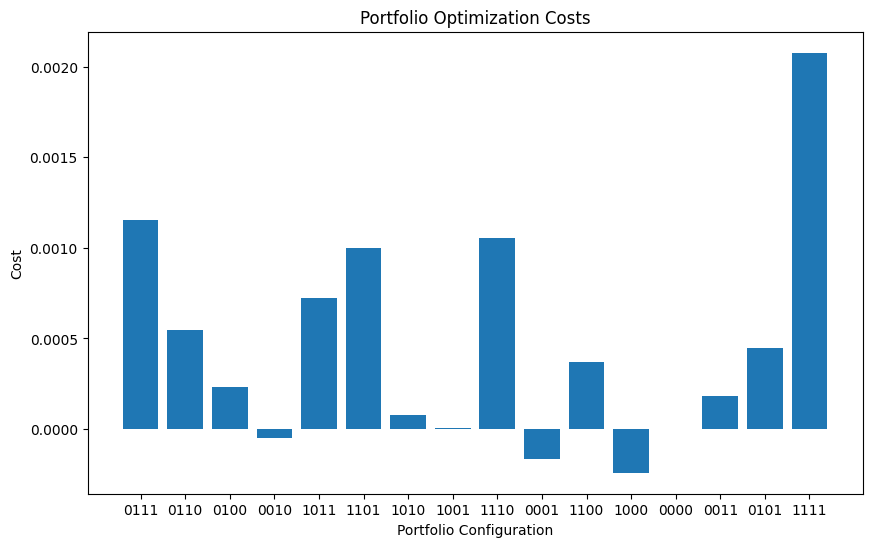

In [9]:
import matplotlib.pyplot as plt

# Plot the costs of different portfolios
portfolio_labels = [''.join(map(str, p)) for p, _ in portfolio_costs]
cost_values = [c for _, c in portfolio_costs]

plt.figure(figsize=(10, 6))
plt.bar(portfolio_labels, cost_values)
plt.xlabel('Portfolio Configuration')
plt.ylabel('Cost')
plt.title('Portfolio Optimization Costs')
plt.show()
